In [1]:
import ROOT
import uproot
import math
import psutil,time
from tqdm import tqdm
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import pickle
import os
import gc
import glob,random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
#from torch.utils.data import Dataset, DataLoader
import warnings
from torch_geometric.data import Data, Dataset,Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import DynamicEdgeConv, global_max_pool,global_mean_pool,knn_graph,MessagePassing
from torch_scatter import scatter_max, scatter_mean,scatter_std, scatter_add
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import ReadRootClusters
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / 1024**3:.2f} GB")
print(f"Used RAM: {mem.used / 1024**3:.2f} GB")
print(f"Available RAM: {mem.available / 1024**3:.2f} GB")
Memory_limit_gb=64  # GB
print("CPU logical cores:", os.cpu_count())
print("CPU physical cores:", psutil.cpu_count(logical=False))
CPU_cores_limit=psutil.cpu_count(logical=False)
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  # mm
CellSize=5.0  # mm
SamplingLayer=30
ECAL_layers=120
Layer_thickness=5.05  # mm
Threshold=Threshold_i*MIP_table[Si]
Cluster_size=16
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
pt_test_dir=f"{DataPath_Validate}/Graph_ClusterSize{Cluster_size}"
pt_uni_dir=f"{DataPath_Uniform}/Graph_ClusterSize{Cluster_size}"

Total RAM: 251.12 GB
Used RAM: 16.48 GB
Available RAM: 234.64 GB
CPU logical cores: 64
CPU physical cores: 32


In [2]:
gc.collect()
def ReadData_Energy(PathIn, PathOut, ParticleEnergy, threshold=0, precision=0.01, Cluster_size=4,MaxEvents=-1):
    if not os.path.exists(PathOut):
        os.makedirs(PathOut)
    max_mem = 0
    for energy_val in ParticleEnergy:
        input_file_name = f"{PathIn}/{energy_val}GeV.root"
        pt_file_name    = f"{PathOut}/{energy_val}GeV.pt"
        print(f"Reading file: {os.path.basename(input_file_name)}")
        event_clusters = ReadRootClusters.read_root_clusters(
            input_file_name,
            threshold=threshold,
            cluster_size=Cluster_size,
            max_events=MaxEvents,
        )
        cluster_features_list, y_list = [], []
        for i, event in enumerate(event_clusters):
            feat = torch.tensor(event.features, dtype=torch.float)
            cluster_features_list.append(feat)
            y_list.append(torch.tensor([event.E_truth], dtype=torch.float))
            if i % 1000 == 0:
                mem = psutil.Process().memory_info().rss / 1024**3
                if mem > max_mem:
                    max_mem = mem
                if mem > Memory_limit_gb:
                    print(f"Memory usage {mem:.2f} GB exceeded limit of {Memory_limit_gb} GB. Stopping.")
                    break
        torch.save(
            {"cluster_features_list": cluster_features_list, "y_list": y_list},
            pt_file_name
        )
        print(f"Saved processed data to {pt_file_name}")

def ReadData_Uniform(PathIn, PathOut, threshold=0, precision=0.01, Cluster_size=4, MaxEvents=-1):
    if not os.path.exists(PathOut):
        os.makedirs(PathOut)

    max_mem = 0
    root_files = [os.path.join(PathIn, f) for f in os.listdir(PathIn) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {PathIn}")

    for input_file in root_files:
        print(f"Reading file: {os.path.basename(input_file)}")
        pt_file_name = f"{PathOut}/{os.path.basename(input_file).replace('.root','.pt')}"
        Events = ReadRootClusters.read_root_clusters(
            input_file,
            threshold=threshold,
            cluster_size=Cluster_size,
            max_events=MaxEvents,
        )

        cluster_features_list, y_list = [], []

        for i, c in enumerate(Events):
            feat = torch.tensor(c.features, dtype=torch.float)
            cluster_features_list.append(feat)
            y_list.append(torch.tensor([c.E_truth], dtype=torch.float))
            if i % 1000 == 0:
                mem = psutil.Process().memory_info().rss / 1024**3
                if mem > max_mem:
                    max_mem = mem
                if mem > Memory_limit_gb:
                    print(f"Memory usage {mem:.2f} GB exceeded limit of {Memory_limit_gb} GB. Stopping.")
                    break
        torch.save({
            "cluster_features_list": cluster_features_list,
            "y_list": y_list
        }, pt_file_name)
        print(f"Saved processed data to {pt_file_name}")

Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#Energy_test=(60.0,)
ReadData_Energy(DataPath_Validate,pt_test_dir,threshold=Threshold,ParticleEnergy=Energy_test,Cluster_size=Cluster_size, MaxEvents=-1)
ReadData_Uniform(DataPath_Uniform,pt_uni_dir,threshold=Threshold,Cluster_size=Cluster_size, MaxEvents=-1)


Reading file: 0.1GeV.root
Saved processed data to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Graph_ClusterSize16/0.1GeV.pt
Reading file: 0.25GeV.root
Saved processed data to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Graph_ClusterSize16/0.25GeV.pt
Reading file: 0.5GeV.root
Saved processed data to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Graph_ClusterSize16/0.5GeV.pt
Reading file: 1.0GeV.root
Saved processed data to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Graph_ClusterSize16/1.0GeV.pt
Reading file: 2.0GeV.root
Saved processed data to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Graph_ClusterSize16/2.0GeV.pt
Reading 

/tmp/ipykernel_1159890/2866378494.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_file_name)


cluster length: 12495 E_truth length: 12495
torch.Size([563, 70])


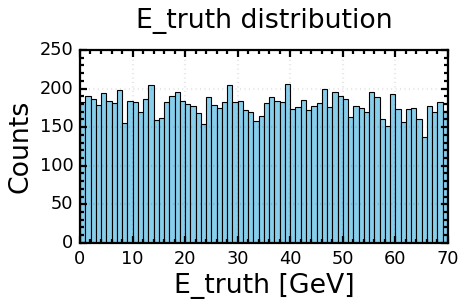

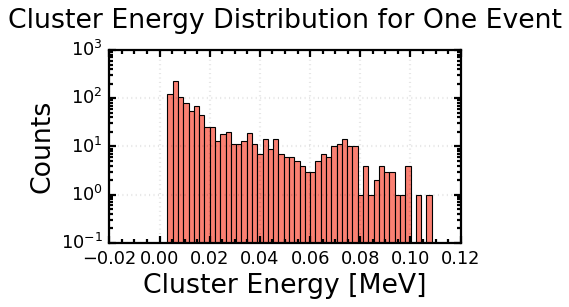

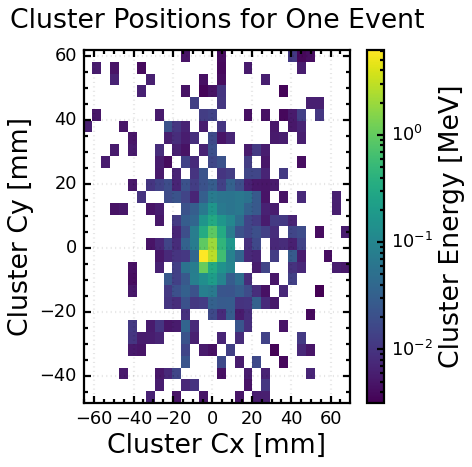

In [3]:
# pt_dir = f"{DataPath_Validate}/Graph_K{KNN_K}"
# pt_file_name = f"{pt_dir}/10.0GeV.pt"
#pt_file_name = f"{pt_test_dir}/60.0GeV.pt"
pt_file_name = f"{pt_uni_dir}/0_70GeV_37.pt"
data = torch.load(pt_file_name)
cluster_features_list = data["cluster_features_list"]
y_list = data["y_list"]
print("cluster length:", len(cluster_features_list),"E_truth length:", len(y_list))
print(cluster_features_list[0].shape)
expected_feat_size = Cluster_size * 4 + 6  # cluster_size=4 -> 4*4+6=22
for i, clusters in enumerate(cluster_features_list):
    if clusters.shape[1] != expected_feat_size:
        print(f"Event {i} feature size mismatch: {clusters.shape[1]}")




E_truth = np.array([y.item() for y in y_list])

# --------------------------
# E_truth histogram
plt.figure(figsize=(6,4))
plt.hist(E_truth, bins=70, color='skyblue')
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.xlim(0, 70)
plt.title("E_truth distribution")
plt.tight_layout()
plt.show()
# --------------------------
#Draw cluster features for one event
cluster_features = cluster_features_list[4]
cluster_energies = cluster_features[:, -6].numpy()
plt.figure(figsize=(6,4))
plt.hist(cluster_energies, bins=50, color='salmon', log=True)
plt.xlabel("Cluster Energy [MeV]")
plt.ylabel("Counts")
plt.title("Cluster Energy Distribution for One Event")
plt.tight_layout()
plt.show()
cluster_cx = cluster_features[:, -3].numpy()
cluster_cy = cluster_features[:, -2].numpy()
plt.figure(figsize=(6,6))
plt.hist2d(cluster_cx, cluster_cy, bins=30, weights=cluster_energies,
           norm=colors.LogNorm(), cmap='viridis')
plt.colorbar(label='Cluster Energy [MeV]')
plt.xlabel("Cluster Cx [mm]")
plt.ylabel("Cluster Cy [mm]")
plt.title("Cluster Positions for One Event")
plt.tight_layout()
plt.show()

In [4]:
print("Memory usage before data loading: {:.2f} GB".format(psutil.Process().memory_info().rss / 1024**3))
val_split = 0.2
pt_uni_files = sorted(glob.glob(f"{pt_uni_dir}/*.pt"))
random.seed(random_state)
random.shuffle(pt_uni_files)
n_val = int(len(pt_uni_files) * val_split)
data_list_val = pt_uni_files[:n_val]
data_list_train = pt_uni_files[n_val:]
#data_list_val = pt_uni_files[:1]
#data_list_train = pt_uni_files[1:2]
data_list_test = sorted(glob.glob(f"{pt_test_dir}/*.pt"))
#data_list_train = data_list_test
#data_list_val = data_list_test
class MultiGraphFileDataset(Dataset):
    def __init__(self, file_list, event_limit=None):
        super().__init__()
        self.file_list = file_list
        self.file_offsets = []
        total = 0
        for fpath in tqdm(file_list, desc="Indexing files"):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore",
                                      category=FutureWarning,
                                      message=r"You are using `torch\.load` with `weights_only=False`"),
                data_list = torch.load(fpath, map_location='cpu')
            n = len(data_list["y_list"])  # 假设 x_list, edge_list, y_list 长度一致
            self.file_offsets.append((total, total + n, fpath))
            total += n
        self.total_samples = total
        self.cache = {"fpath": None, "data_dict": None}
        self.event_limit = event_limit
    def __len__(self):
        #return self.total_samples
        if self.event_limit is not None:
            return min(self.total_samples, self.event_limit)
        return self.total_samples
    def __getitem__(self, idx):
        if self.event_limit is not None and idx >= self.event_limit:
            raise IndexError(f"Index {idx} exceeds event limit of {self.event_limit}")
        for start, end, fpath in self.file_offsets:
            if start <= idx < end:
                local_idx = idx - start
                if self.cache["fpath"] != fpath:
                    with warnings.catch_warnings():
                        warnings.filterwarnings(
                            "ignore",
                            category=FutureWarning,
                            message=r"You are using `torch\.load` with `weights_only=False`"
                        )
                        self.cache["data_dict"] = torch.load(fpath, map_location="cpu")
                    self.cache["fpath"] = fpath
                data_dict = self.cache["data_dict"]
                x = data_dict["cluster_features_list"][local_idx]
                y = data_dict["y_list"][local_idx]
                return Data(x=x, y=y)
        raise IndexError(f"Index {idx} out of range")
        
train_dataset = MultiGraphFileDataset(file_list=data_list_train)
val_dataset = MultiGraphFileDataset(file_list=data_list_val)
test_dataset = MultiGraphFileDataset(file_list=data_list_test)
print("Memory usage after data loading: {:.2f} GB".format(psutil.Process().memory_info().rss / 1024**3))

Memory usage before data loading: 8.74 GB


Indexing files: 100%|██████████| 12/12 [01:27<00:00,  7.27s/it]

Memory usage after data loading: 8.75 GB


In [ ]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        abs_rel = torch.abs(rel)
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = x
        #out = self.activation(out)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out
    
#General MLP with residual blocks, no need for input dim
class MLPRegressor(nn.Module):
    def __init__(self, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.inferred_input_dim = None
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        layers.append(nn.Sequential(
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(hidden_dims[0]),
            activation,
            nn.Dropout(dropout)
        ))
        prev_dim = hidden_dims[0]
        for h in hidden_dims[1:]:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h

        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)  # 输出事件预测

    def forward(self, x):
        if self.inferred_input_dim is None:
            self.inferred_input_dim = x.shape[-1]
            print(f"MLP input dim: {self.inferred_input_dim}")
        x = self.model(x)
        # return self.output_layer(x).squeeze(-1)
        return x

class ClusterConv(nn.Module):
    def __init__(self, hidden_layers=[32,32,32], dropout=0.1, activation=nn.PReLU(), tau=0.1):
        super().__init__()
        self.mlp = MLPRegressor(hidden_dims=hidden_layers, dropout=dropout, activation=activation)
        self.tau = tau

    def forward(self, x, batch):
        out = self.mlp(x)  # (N, F)
        # mean
        mean = scatter_mean(out, batch, dim=0)
        # max
        max_val, _ = scatter_max(out, batch, dim=0)
        # soft median
        diff = torch.abs(out - mean[batch])          # (N, F)
        w = torch.exp(-diff / self.tau)              # (N, F)
        w_sum = scatter_add(w, batch, dim=0)         # (G, F)
        wx_sum = scatter_add(w * out, batch, dim=0)  # (G, F)
        soft_median = wx_sum / (w_sum + 1e-9)        # (G, F)
        # energy-weighted mean
        Eweight = x[:, :-6].sum(dim=1, keepdim=True)             # (N, 1)
        Esum = scatter_add(Eweight, batch, dim=0)                # (G, 1)
        Eweighted_sum = scatter_add(out * Eweight, batch, dim=0) # (G, F)
        Eweighted_sum = torch.where(Esum == 0,
                                    torch.zeros_like(Eweighted_sum),
                                    Eweighted_sum / Esum)

        # concat
        global_feat = torch.cat([mean, max_val, soft_median, Eweighted_sum], dim=-1)
        return global_feat



class DGCNN_MLP(nn.Module):
    def __init__(self, Conv_hidden=[128,64,32], mlp_hidden=[128,64,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.convs = ClusterConv(hidden_layers=Conv_hidden, dropout=dropout, activation=activation)
        self.mlp = MLPRegressor(hidden_dims=mlp_hidden, dropout=dropout, activation=activation)
        self.energy_output_layer = nn.Linear(mlp_hidden[-1], 1)

    def forward(self, data):
        x, batch = data.x, data.batch  # batch: (total_clusters,)
        x = self.convs(x, batch)       # (batch_size, out_features*4)

        # 如果有额外信息，也按 batch_size 拼接
        if hasattr(data, 'extra') and data.extra is not None:
            combined = torch.cat([x, data.extra], dim=-1)
        else:
            combined = x

        out = self.mlp(combined)                  # (batch_size, mlp_hidden[-1])
        out = self.energy_output_layer(out).squeeze(-1)  # (batch_size,)
        return out


In [ ]:
def train_dgcnn(train_loader, val_loader,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
            Conv_hidden=[128, 64,32],
              mlp_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=30,
              patience=10,
              val_split=0.2,
              random_state=42,
              model_name="DGCNN_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Memory usage before training: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")
    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")

    # Model
    model = DGCNN_MLP(
        Conv_hidden=Conv_hidden,
        mlp_hidden=mlp_dims,
        dropout=dropout,
        activation=activation
    ).to(device)
    
    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch <= warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = (epochs/50) * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
            mem = psutil.Process().memory_info().rss / 1024**3
            if mem > Memory_limit_gb:
                print(f"Memory usage {mem:.2f} GB exceeded limit of {Memory_limit_gb} GB. Stopping training.")
                return model, None, None, None
        scheduler.step()        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = criterion(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)
        val_loss   /= len(val_loader.dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}|LR: {scheduler.get_last_lr()[0]:.6f} | patience: {patience_counter} | Memory usage: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            if (best_val_loss - val_loss) / best_val_loss > 0.01:
                patience_counter = 0
            best_val_loss = val_loss
            best_state_dict = model.state_dict()    
            torch.save(model, model_name)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            y_val_true.append(batch.y.cpu())
            y_val_pred.append(pred.cpu())
    y_val_true = torch.cat(y_val_true, dim=0).numpy()
    y_val_pred = torch.cat(y_val_pred, dim=0).numpy()
    return model,y_val_true, y_val_pred,best_val_loss

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
gpu_memory = torch.cuda.memory_allocated() / 1024**3
gpu_reserved = torch.cuda.memory_reserved() / 1024**3
print(f"GPU allocated: {gpu_memory:.2f} GB, reserved: {gpu_reserved:.2f} GB")
BatchSize = 4096
train_loader = DataLoader(train_dataset, batch_size=BatchSize, num_workers=CPU_cores_limit//4,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BatchSize, num_workers=CPU_cores_limit//4,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False, num_workers=CPU_cores_limit//4,pin_memory=True)
CONF_NAME=f"DGCNN_ClusterSize{Cluster_size}_WD1e-12"
print(f"Training DGCNN with configuration: {CONF_NAME}")
model_name = DataPath_Validate+f"/Models/{CONF_NAME}.pth"
dgcnn_model, y_val_true, y_val_pred, best_val_loss = train_dgcnn(
    train_loader=train_loader,
    val_loader=val_loader,
    activation=nn.PReLU(),
    loss=HuberRelativeLoss(delta=0.05),
    Conv_hidden=[128, 64,32],
    mlp_dims=[128, 64, 32],
    dropout=0.1,
    lr=5e-4,
    weight_decay=1e-12,
    batch_size=BatchSize,
    epochs=1,
    patience=10,
    val_split=0.2,
    random_state=random_state,
    model_name=model_name
)
# Evaluate on test set

GPU allocated: 0.42 GB, reserved: 0.72 GB
Training DGCNN with configuration: ClusterSize16_WD1e-12
Memory usage before training: 20.09 GB
Using device: cuda
Random state: 42
Training samples: 999720, Validation samples: 249933
learning rate: 0.0005, batch size: 4096, epochs: 1, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
MLP input dim: 70
MLP input dim: 128


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbf2b5cec50>>
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/data_ilc/flc/shi/miniconda3/envs/GNN/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
device = next(dgcnn_model.parameters()).device
dgcnn_model.eval()
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = dgcnn_model(batch)
        y_test_true.append(batch.y.cpu())
        y_test_pred.append(pred.cpu())
y_test_true = torch.cat(y_test_true, dim=0).numpy()
y_test_pred = torch.cat(y_test_pred, dim=0).numpy()
Data_out ={
    "y_val_true": y_val_true,
    "y_val_pred": y_val_pred,
    "y_test_true": y_test_true,
    "y_test_pred": y_test_pred,
    "best_val_loss": best_val_loss
}
with open(f'{DataPath_Validate}/Hist/{CONF_NAME}.pkl', 'wb') as f:
    pickle.dump(Data_out, f)
print("Saved results to ",f'{DataPath_Validate}/Hist/{CONF_NAME}.pkl')

Saved results to  /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Hist/DGCNN_ClusterSize16_WD1e-12.pkl
